5. Neste exercício você vai utilizar o arquivo reg_poli.csv onde a primeira coluna são os valores de x (atributo) e a segunda de y (objetivo ou rótulo). Após, leia o conteúdo do arquivo, ou seja, os vetores x e y, com os seguintes comandos:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv(‘./reg_poli.csv', header=None)
x = df[0].to_numpy()
y = df[1].to_numpy()
x = x.reshape(len(x), 1)
y = y.reshape(len(y), 1)
fig = plt.figure(figsize=(10,10))
plt.plot(x, y, 'b.')
Em seguida
a. Apresente o gráfico de x versus y, mostrando os pontos amostrados do modelo gerador.
b. Encontre uma aproximação polinomial que represente bem os dados do arquivo. Para encontrar a melhor aproximação, utilize os seguintes métodos: validação cruzada holdout (com 70% do conjunto original para treinamento e 30% para
validação), validação cruzada k-fold (com k=10 folds), validação cruzada leave-p-out (com p=1) e curvas de aprendizado. Analise polinômios com ordem variando de 1 até 12.
c. Em seguida, de posse da melhor ordem de polinômio que aproxima os dados do arquivo csv, treine o modelo com todos os dados do arquivo csv. Utilize padronização de atributos com a classe StandardScaler da biblioteca SciKit-Learn.
d. Plote um gráfico que mostre os pontos ruidosos do arquivo csv e os valores encontrados com o modelo para dos valores de x vindos do arquivo csv.

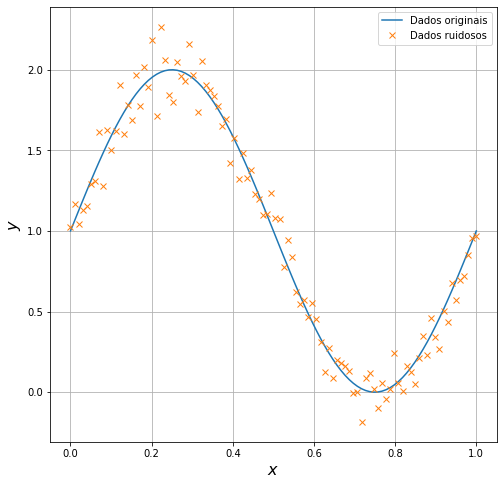

In [17]:
# Import all the necessary libraries.
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import LeavePOut
import csv
import pandas as pd

# Example set size.
M = 100

# Semente aleatória
np.random.seed(25)

def target_function(M, x):
    y = 1 + np.sin(2*np.pi*x)
    y = y.reshape(M, 1)
    y_noisy = y + 0.1*np.random.randn(M, 1)
    return y, y_noisy

x = np.linspace(0, 1, M).reshape(M, 1)
y, y_noisy = target_function(M, x)

i = 0
writer = csv.writer(open("D:/Mestrado/Joao-852-tp555/lista3/reg_poli.csv", 'w'), delimiter=',')
for row in y_noisy:
    writer.writerow((x[i][0], y_noisy[i][0]))
    i = i + 1
    
df = pd.read_csv('D:/Mestrado/Joao-852-tp555/lista3/reg_poli.csv', header=None)

x = df[0].to_numpy()
y_noisy = df[1].to_numpy()
           
x = x.reshape(len(x),1)
y_noisy = y_noisy.reshape(len(x),1)

# Plot cost-function surface.
fig = plt.figure(figsize=(8,8))
plt.plot(x, y, label='Dados originais')
plt.plot(x, y_noisy, 'x', label='Dados ruidosos')
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16)
plt.legend()
plt.grid()
#Show the plot.
plt.show()

In [18]:
# holdout (70/30%)
# Split the whole set into random training and validation set.
x_train, x_val, y_train, y_val = train_test_split(x, y_noisy, test_size=0.3, random_state=25)

print('tamanho conjunto de treinamento:', len(y_train))
print('tamanho conjunto de validação:', len(y_val))

include_bias = True
mean_vec = []
train_vec = []

for d in range(1, 13):
    # Instantiate a polynomial.
    poly_features = PolynomialFeatures(degree=d, include_bias=include_bias)
    # Instantiate a scaler.
    std_scaler = StandardScaler()
    # Instantiate a linear regressor.
    lin_reg = LinearRegression()

    # Create a pipeline of actions.
    polynomial_regression = Pipeline([
        ("poly_features", poly_features),
        ("std_scaler", std_scaler),
        ("lin_reg", lin_reg),
    ])

    polynomial_regression.fit(x_train, y_train)
    
    y_train_predict = polynomial_regression.predict(x_train)
    
    y_val_predict = polynomial_regression.predict(x_val)
    
    train_vec.append(np.sqrt(mean_squared_error(y_train, y_train_predict)))
    
    mean_vec.append(np.sqrt(mean_squared_error(y_val, y_val_predict)))

tamanho conjunto de treinamento: 70
tamanho conjunto de validação: 30


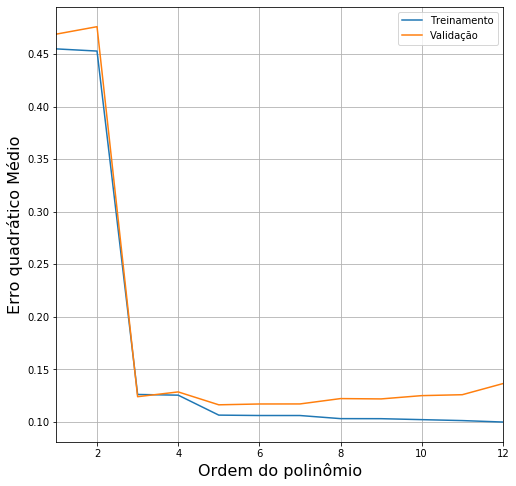

In [19]:
# Plot results.
plt.figure(figsize=(8, 8))
plt.plot(range(1, 13), train_vec, label='Treinamento')
plt.plot(range(1, 13), mean_vec, label='Validação')
plt.xlabel('Ordem do polinômio', fontsize=16)
plt.ylabel('Erro quadrático Médio', fontsize=16)
plt.xticks(range(0, 13, 2))
plt.xlim([1, 12])
plt.legend()
plt.grid()
#Show the plot.
plt.show()

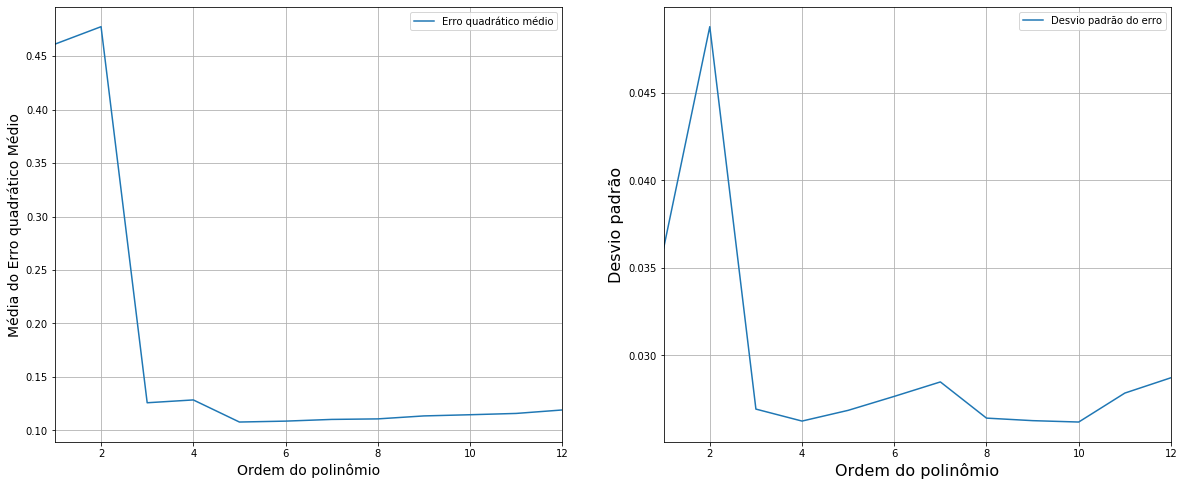

In [20]:
# Instantiate the k-Fold object.
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

mean_vec = []
std_vec = []
for d in range(1, 13):
    # Instantiate a polynomial.
    poly_features = PolynomialFeatures(degree=d, include_bias=include_bias)
    # Instantiate a scaler.
    std_scaler = StandardScaler()
    # Instantiate a linear regressor.
    lin_reg = LinearRegression()

    # Create a pipeline of actions.
    polynomial_regression = Pipeline([
        ("poly_features", poly_features),
        ("std_scaler", std_scaler),
        ("lin_reg", lin_reg),
    ])

    lin_scores = cross_val_score(polynomial_regression, x, y_noisy, scoring='neg_mean_squared_error', cv=kfold)
        
    scores = np.sqrt(-lin_scores)
    mean_vec.append(scores.mean())
    std_vec.append(scores.std())
    
# Plot results.
plt.figure(figsize=(20, 8))
ax = plt.subplot(1, 2, 1)
plt.plot(range(1, 13), mean_vec,  label='Erro quadrático médio')
plt.xlabel('Ordem do polinômio', fontsize=14)
plt.ylabel('Média do Erro quadrático Médio', fontsize=14)
plt.xticks(range(0, 13, 2))
plt.xlim([1, 12])
plt.legend()
plt.grid()

ax = plt.subplot(1, 2, 2)
plt.plot(range(1, 13), std_vec,  label='Desvio padrão do erro')
plt.xlabel('Ordem do polinômio', fontsize=16)
plt.ylabel('Desvio padrão', fontsize=16)
plt.xticks(range(0, 13, 2))
plt.xlim([1, 12])
plt.legend()
plt.grid()

#Show the plot.
plt.show()

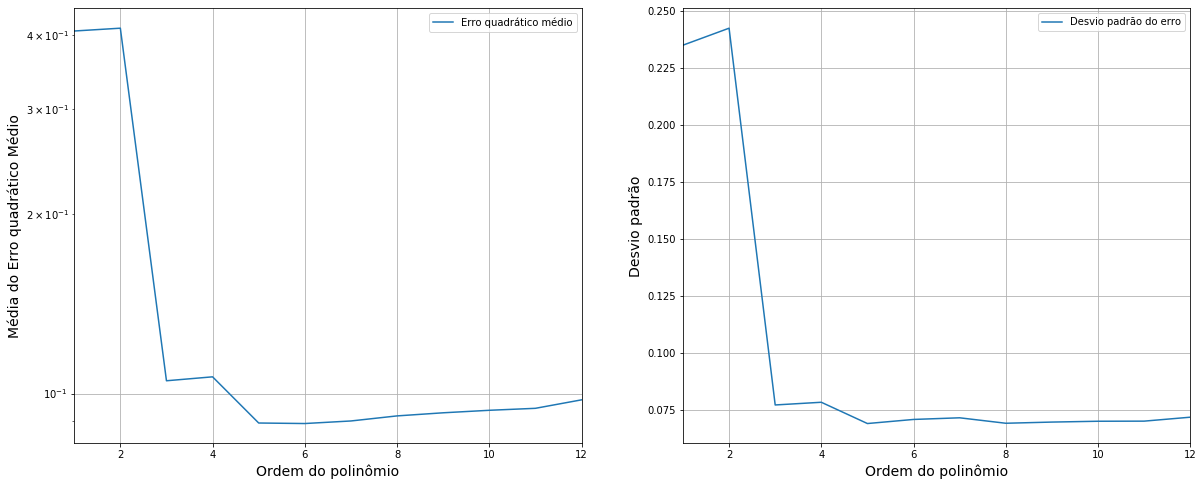

In [21]:
# Leave-p-out (p=1)
# Instantiate the LOOCV object.
loocv = LeaveOneOut()

mean_vec = []
std_vec = []
for d in range(1, 13):
    # Instantiate a polynomial.
    poly_features = PolynomialFeatures(degree=d, include_bias=include_bias)
    # Instantiate a scaler.
    std_scaler = StandardScaler()
    # Instantiate a linear regressor.
    lin_reg = LinearRegression()

    # Create a pipeline of actions.
    polynomial_regression = Pipeline([
        ("poly_features", poly_features),
        ("std_scaler", std_scaler),
        ("lin_reg", lin_reg),
    ])

    lin_scores = cross_val_score(polynomial_regression, x, y_noisy, scoring='neg_mean_squared_error', cv=loocv)
        
    scores = np.sqrt(-lin_scores)
    mean_vec.append(scores.mean())
    std_vec.append(scores.std())
    
# Plot 
plt.figure(figsize=(20, 8))
ax = plt.subplot(1, 2, 1)
plt.plot(range(1, 13), mean_vec,  label='Erro quadrático médio')
plt.xlabel('Ordem do polinômio', fontsize=14)
plt.ylabel('Média do Erro quadrático Médio', fontsize=14)
plt.yscale('log')
plt.xticks(range(0, 13, 2))
plt.xlim([1, 12])
plt.legend()
plt.grid()

ax = plt.subplot(1, 2, 2)
plt.plot(range(1, 13), std_vec,  label='Desvio padrão do erro')
plt.xlabel('Ordem do polinômio', fontsize=14)
plt.ylabel('Desvio padrão', fontsize=14)
plt.xticks(range(0, 13, 2))
plt.xlim([1, 12])
plt.legend()
plt.grid()

plt.show()